# クラウドソーシング結果の整理

目的：

    1. クラウドソーシングの結果を整理し，機械学習可能なデータにしておく．
    2. クラウドソーシングの結果を分析し，評価を行う．

In [32]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import japanize_matplotlib

In [3]:
df = pd.read_csv("results/Batch_4749224_batch_results.csv")

In [6]:
df.columns

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.image_url',
       'Answer.face impressions.labels', 'Approve', 'Reject'],
      dtype='object')

In [7]:
df[0:3]

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,RejectionTime,RequesterFeedback,WorkTimeInSeconds,LifetimeApprovalRate,Last30DaysApprovalRate,Last7DaysApprovalRate,Input.image_url,Answer.face impressions.labels,Approve,Reject
0,3XUSYT70IU4OOCQEDITA0OZXCFCD0I,35EE6WR8LH5R4JJ5CG05YH113AV714,Select applicable face impressions.,Please identify ALL applicable face impression...,"categorize, image",$0.02,Fri May 27 00:55:21 PDT 2022,3,BatchId:4749224;OriginalHitTemplateId:928390873;,300,...,NaN,NaN,159,0% (0/0),0% (0/0),0% (0/0),https://www.u.tsukuba.ac.jp/~s*******/mast-ai-...,"[""Caring""]",NaN,NaN
1,3XUSYT70IU4OOCQEDITA0OZXCFCD0I,35EE6WR8LH5R4JJ5CG05YH113AV714,Select applicable face impressions.,Please identify ALL applicable face impression...,"categorize, image",$0.02,Fri May 27 00:55:21 PDT 2022,3,BatchId:4749224;OriginalHitTemplateId:928390873;,300,...,NaN,NaN,46,0% (0/0),0% (0/0),0% (0/0),https://www.u.tsukuba.ac.jp/~s*******/mast-ai-...,"[""Responsible""]",NaN,NaN
2,3XUSYT70IU4OOCQEDITA0OZXCFCD0I,35EE6WR8LH5R4JJ5CG05YH113AV714,Select applicable face impressions.,Please identify ALL applicable face impression...,"categorize, image",$0.02,Fri May 27 00:55:21 PDT 2022,3,BatchId:4749224;OriginalHitTemplateId:928390873;,300,...,NaN,NaN,235,0% (0/0),0% (0/0),0% (0/0),https://www.u.tsukuba.ac.jp/~s*******/mast-ai-...,"[""Caring""]",NaN,NaN


## 結果の分析

### ワーカーあたり回答数の分布

In [8]:
from collections import OrderedDict

In [9]:
counts = OrderedDict()

In [12]:
for record in df["WorkerId"]:
    if record in counts.keys():
        counts[record] += 1
    else:
        counts[record] = 1

In [17]:
counts_sorted = OrderedDict(
    sorted(counts.items(), key=lambda x: x[1], reverse=True)
)

In [48]:
left = np.arange(1,len(counts.keys())+1)
height = np.array(list(counts_sorted.values()))
ratio = np.zeros(len(left))
total_sum = 0
for i,v  in enumerate(height):
    total_sum += v
    ratio[i] = total_sum / 255 * 100

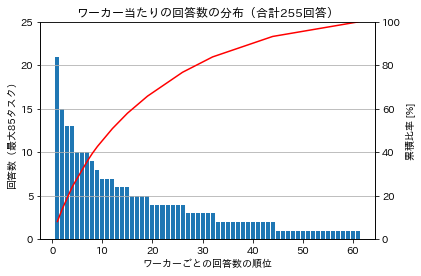

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.bar(left, height)
ax.set_title("ワーカー当たりの回答数の分布（合計255回答）")
ax.set_xlabel("ワーカーごとの回答数の順位")
ax.set_ylabel("回答数（最大85タスク）")

ax_add = ax.twinx()
ax_add.plot(left, ratio, color="red")
ax_add.set_ylim([0, 100])
ax_add.set_ylabel("累積比率 [%]")

plt.grid()
ax.set_ylim([0,25])
plt.plot() ;

全体の1/6のワーカーが約半分を解いていることになる

## データ整理とアグリゲーション

In [65]:
labels = dict()
labels["Caring"] = 0
labels["Confident"] = 1
labels["Emotionally stable"] = 2
labels["Intelligent"] = 3
labels["Responsible"] = 4
labels["Sociable"] = 5
labels["Trustworthy"] = 6

In [62]:
class task:
    def __init__(self, image_id):
        self.image_id = image_id
        self.answers = []

In [57]:
tasks = dict()

In [69]:
for url, ans in zip(df["Input.image_url"], df["Answer.face impressions.labels"]):
    img_id = url[51:-4]
    if not img_id in tasks.keys():
        tasks[img_id] = task(img_id)
    
    ans_trimed = ans[1:-2].replace("\"","")
    ans_list = ans_trimed.split(",")
    ones = [labels[a] for a in ans_list]
    bits = np.zeros(7)
    for i in ones:
        bits[i] = 1
    
    tasks[img_id].answers.append(bits)

## 単純多数決によるアグリゲーション

In [70]:
tasklist = list(tasks.values())

In [72]:
for t in tasklist:
    sumbit = np.zeros(7)
    for ans in t.answers:
        sumbit += ans
    agree = np.zeros(7)
    agree[np.where(sumbit >= 2)] = 1
    t.smv = agree # Simple majority vote

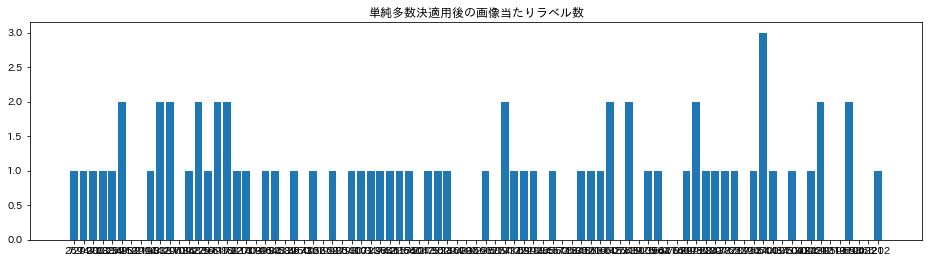

In [85]:
label_num = []
for t in tasks.items():
    label_num.append(t[1].smv.sum())
    
plt.figure(figsize=(16,4))
plt.title("単純多数決適用後の画像当たりラベル数")
plt.bar(tasks.keys(), label_num)
plt.plot() ;

問題点：いくつかのラベルはラベルなしとなってしまう

## 1人でもラベル付けしたものは有効とする場合

In [86]:
for t in tasklist:
    sumbit = np.zeros(7)
    for ans in t.answers:
        sumbit += ans
    agree = np.zeros(7)
    agree[np.where(sumbit >= 1)] = 1
    t.svs = agree # Simple Vote Sum

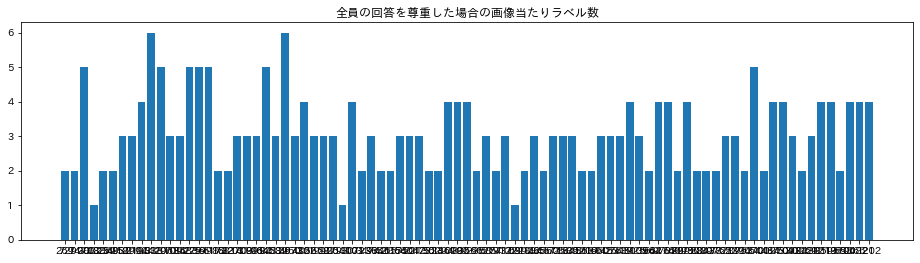

In [88]:
label_num = []
for t in tasks.items():
    label_num.append(t[1].svs.sum())
    
plt.figure(figsize=(16,4))
plt.title("全員の回答を尊重した場合の画像当たりラベル数")
plt.bar(tasks.keys(), label_num)
plt.plot() ;

問題点：ラベルが多すぎる，精度が低い

## 全会一致

In [89]:
for t in tasklist:
    sumbit = np.zeros(7)
    for ans in t.answers:
        sumbit += ans
    agree = np.zeros(7)
    agree[np.where(sumbit >= 3)] = 1
    t.unanimities = agree # unanimities

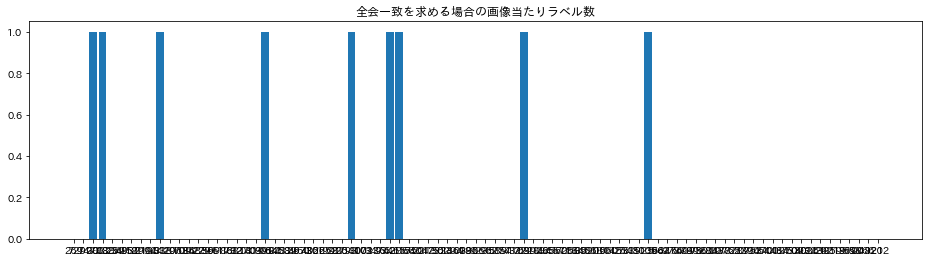

In [92]:
label_num = []
for t in tasks.items():
    label_num.append(t[1].unanimities.sum())
    
plt.figure(figsize=(16,4))
plt.title("全会一致を求める場合の画像当たりラベル数")
plt.bar(tasks.keys(), label_num)
plt.plot() ;

単純多数決が一番ましか・・・

## ラベルの分布

In [93]:
sums = np.zeros(7)
for t in tasklist:
    sums += t.smv

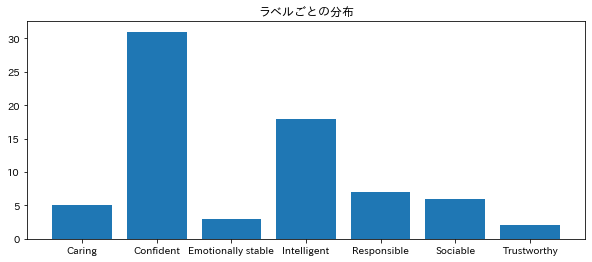

In [101]:
plt.figure(figsize=(10,4))
plt.title("ラベルごとの分布")
plt.bar(labels.keys(), sums)
plt.plot() ;

選択肢の上が多いなどは特になさそう?

# データを書き込む

In [134]:
records = []  
for t in tasklist:
    record = [t.image_id]
    record.extend(t.smv)
    records.append(record)

In [135]:
cols = ["Id"]
cols.extend(labels.keys())
csv = pd.DataFrame(records, columns=cols)

In [136]:
csv

,Id,Caring,Confident,Emotionally stable,Intelligent,Responsible,Sociable,Trustworthy
0,269,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,72998,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,74783,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,30823,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,08848,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
80,85955,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,13100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
82,69866,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,24821,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
csv.to_csv("../data1.csv", index=None)